# Image generation

We have embeddings of the keywords of hundreds of popular movies and a pre-trained image classification network. We'll be using the network for feature extraction, then backpropagating through it to make the image features match movie vectors.

## Loading

In [12]:
import pandas as pd
import numpy as np
import skimage.io
import torch
import torchvision
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import os
import shutil

In [2]:
movies = pd.read_csv('movies/processed.csv')
movie_vectors = np.array([np.fromstring(vector, sep=' ') for vector in movies['vector']])
print(f'movie_vectors: shape {movie_vectors.shape}, std {movie_vectors.std()}')

movie_vectors: shape (256, 256), std 0.13175606533853548


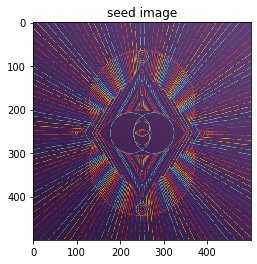

In [3]:
seed_image = skimage.io.imread('seed_image.jpg')
seed_image = seed_image.astype(float) / 255
plt.title('seed image')
plt.imshow(seed_image)
plt.show()

In [4]:
densenet = torchvision.models.densenet161(pretrained=True)
densenet.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## Feature extraction

In [5]:
norm_means = torch.tensor([0.485, 0.456, 0.406])
norm_stds = torch.tensor([0.229, 0.224, 0.225])

def normalize_image(image):
    assert image.shape[-1] == 3
    return (image - norm_means) / norm_stds

def unnormalize_image(image):
    assert image.shape[-1] == 3
    return image * norm_stds + norm_means

In [6]:
def features(image):
    if not isinstance(image, torch.Tensor):
        image = torch.tensor(image, dtype=torch.float)
    image = normalize_image(image)
    image = image.permute(2, 0, 1).unsqueeze(0)
    result = densenet.features(image)
    result = result.squeeze(0).permute(1, 2, 0)
    return result.flatten(end_dim=-2)

In [7]:
seed_features = features(seed_image).detach().numpy()
feature_pca = PCA().fit(seed_features)
pca_mean = torch.tensor(feature_pca.mean_, dtype=torch.float)
pca_matrix = torch.tensor(feature_pca.components_.T, dtype=torch.float)

In [8]:
def principal_features(image):
    all_features = features(image)
    return torch.matmul(all_features - pca_mean, pca_matrix)

## Generation

In [22]:
seed_principal_features = feature_pca.transform(seed_features)
seed_principal_stds = seed_principal_features.std(axis=0)
movie_vector_stds = movie_vectors.std(axis=0)[:feature_pca.n_components_]
vector_scaling = torch.tensor(seed_principal_stds / movie_vector_stds)

def normalize_vector(vector):
    '''map a vector from movie embedding space to principal image feature space'''
    if not isinstance(vector, torch.Tensor):
        vector = torch.tensor(vector, dtype=torch.float)
    return vector[:feature_pca.n_components_] * vector_scaling

In [23]:
def conform_image(image, vector, num_steps=64):
    '''optimize image so that its principal features match those provided in vector'''
    vector = normalize_vector(vector)
    target_features = torch.stack([vector] * seed_features.shape[0])
    image_unbound = -np.log(1 / image - 1) # inverse sigmoid
    image_unbound = torch.tensor(image_unbound, dtype=torch.float, requires_grad=True)
    
    optimizer = torch.optim.Adam([image_unbound], lr=1e-1)
    criterion = torch.nn.MSELoss()
    for step in trange(num_steps):
        image_bound = torch.sigmoid(image_unbound)
        current_features = principal_features(image_bound)
        loss = criterion(current_features, target_features)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return torch.nn.functional.sigmoid(image_unbound)

## It's preview time!

In [ ]:
example_conformed = conform_image(seed_image, movie_vectors[0])
plt.title('example generated image')
plt.imshow(example_conformed)
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/malyvsen/creative/software/ai/inverse-ai/inverse-ai-venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-d790ea55e641>", line 1, in <module>
    example_conformed = conform_image(seed_image, movie_vectors[0])
  File "<ipython-input-23-346215a749c4>", line 13, in conform_image
    loss = criterion(current_features, target_features)
  File "/home/malyvsen/creative/software/ai/inverse-ai/inverse-ai-venv/lib/python3.7/site-packages/torch/nn/modules/module.py", line 541, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/malyvsen/creative/software/ai/inverse-ai/inverse-ai-venv/lib/python3.7/site-packages/torch/nn/modules/loss.py", line 431, in forward
    return F.mse_loss(input, target, reduction=self.reduction)
  File "/home/malyvsen/creative/software/ai/inverse-ai/inverse-ai-venv/lib/python3.7/site-packag

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'target' in call to _thnn_mse_loss_forward

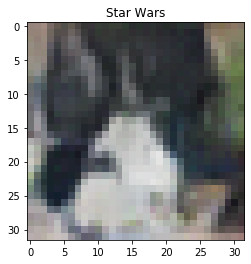

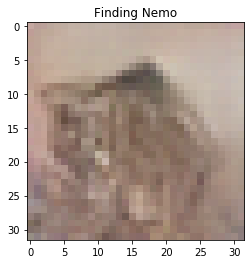

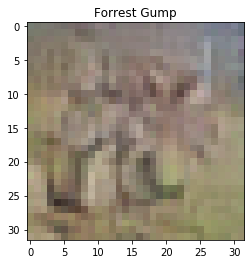

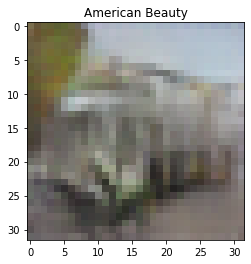

In [5]:
for image, (index, row) in zip(images[:4], movies.iterrows()):
    plt.title(row['title'])
    plt.imshow(image)
    plt.show()

In [6]:
output_dir = 'generated'
shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

for image, (index, row) in zip(images, movies.iterrows()):
    filename = ''.join(char for char in row['title'] if char.isalnum() or char == ' ')
    image_uint8 = (image * 255.5).astype(np.uint8)
    imsave(f'{output_dir}/{filename}.png', image_uint8)

/home/malyvsen/creative/software/ai/inverse-ai/inverse-ai-venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: generated/Back to the Future.png is a low contrast image
  
